### Generative Adversarial Networks
**Refinements will be made later!

In [34]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np
from matplotlib import pyplot as plt

In [35]:
# Load data
def gen_data():
    compose = transforms.Compose([transforms.ToTensor()])
    out_dit = './dataset'
    
    return datasets.MNIST(root=out_dit,train='True',transform=compose,download=True)

In [36]:
# Define Discriminator

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.ly1 = nn.Sequential(
            nn.Linear(n_features,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.ly2 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.ly3 = nn.Sequential(
            nn.Linear(256,n_out),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.ly1(x)
        x = self.ly2(x)
        x = self.ly3(x)
        return x        

In [5]:
# Define Generator

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        n_features = 128
        n_out = 784
        
        self.ly1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.ly2 = nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        
        self.ly3 = nn.Sequential(
            nn.Linear(512,n_out),
            nn.Tanh()
        )
    
    def forward(self,x):
        x = self.ly1(x)
        x = self.ly2(x)
        x = self.ly3(x)
        return x
    
    

In [6]:
# Define noise function

def noise(size):
    n = Variable(torch.rand(size,128))
    return n

In [7]:
# Convert image

def image_to_vector(image):
    return image.view(image.size(0), 784)

def vector_to_image(vector):
    return vector.view(vector.size(0),1,28,28)

In [37]:
# Define discriminator/Generator training function

def train_discriminator(optimizer,real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()
    
    # Train on Real data
    
    predict_real = discriminator(real_data)
    loss_real = loss(predict_real,Variable(torch.ones(N, 1)))
    loss_real.backward()
    
    # Train on Fake data
    
    predict_fake = discriminator(fake_data)
    loss_fake = loss(predict_fake,Variable(torch.zeros(N, 1)))
    loss_fake.backward()
    
    optimizer.step()
    
    return loss_real + loss_fake, predict_real, predict_fake

In [39]:
def train_generator(optimizer, fake_data):
    
    N = fake_data.size(0)
    optimizer.zero_grad()
    
    # generate fake data
    predict = discriminator(fake_data)
    loss_g = loss(predict, Variable(torch.ones(N, 1)))
    loss_g.backward()
    
    optimizer.step()
    
    return loss_g

In [40]:
# Load data
data = gen_data()
# Creat loader to iterate
# Batch size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=100,shuffle = True)
n_batches = len(data_loader)
discriminator = Discriminator()
generator = Generator()

# Use ADAM as optimizer

d_opt = optim.Adam(discriminator.parameters(),lr = 0.0005)
g_opt = optim.Adam(generator.parameters(),lr = 0.0005)

# Use BCE loss
loss = nn.BCELoss()

In [ ]:
n_epochs = 50
num_test_samples = 16
test_noise = noise(num_test_samples)
d_losses = []
g_losses = []
images = []

for epoch in range(n_epochs):
    dloss = 0.0
    gloss = 0.0
    
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # Train discriminator
        # Real data
        real_data = Variable(image_to_vector(real_batch))
        
        # Generate fake data
        fake_data = generator(noise(N)).detach()
        
        
        d_loss, d_pred_real, d_pred_fake = train_discriminator(d_opt, real_data, fake_data)
        
        # Train generator
        # generate fake data
        fake_data = generator(noise(N))
        
        g_loss = train_generator(g_opt, fake_data)
        
        dloss += d_loss
        gloss += g_loss
        
        if (epoch) % 10 == 0: 
            test_images = vector_to_image(generator(test_noise))
            test_images = test_images.data
    
    
    print("An epoch is finished!")
    
    if (epoch) % 10 == 0:
        images.append(test_images)
    
    d_losses.append(dloss/len(data_loader))
    g_losses.append(gloss/len(data_loader))
        

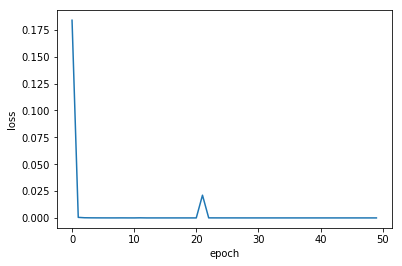

In [53]:
plt.plot(d_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('disloss.png')

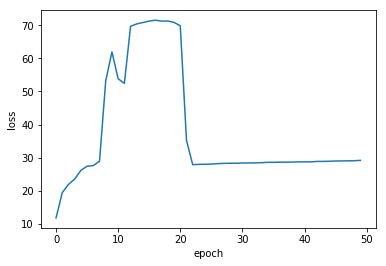

In [55]:
plt.plot(g_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('genloss.png')

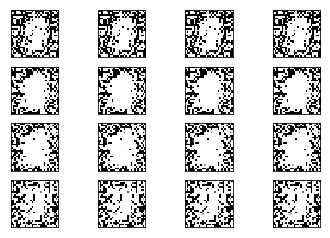

In [61]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)

for noisy_imgs, row in zip(images, axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(img.reshape(28,28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig('GAN.png')